In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks

os.chdir('./OCTA_CycleGAN/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks


In [ ]:
# Prepare package
!pip install visdom
!pip install lpips

In [ ]:
# !git clone https://github.com/fbcotter/pytorch_wavelets
%cd ./pytorch_wavelets/
!pip install .
%cd ../

/content/drive/MyDrive/Colab Notebooks/OCTA_CycleGAN/pytorch_wavelets
Processing /content/drive/MyDrive/Colab Notebooks/OCTA_CycleGAN/pytorch_wavelets
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for pytorch-wavelets: filename=pytorch_wavelets-1.3.0-py3-none-any.whl size=54869 sha256=1502e035967dfc9a905d0ad3caef91c0013ed6b54985f717cdaf1cc57fbf0fc1
  Stored in directory: /tmp/pip-ephem-wheel-cache-8gb3dn3o/wheels/82/1f/1d/df88cea24a9de9a259b29c50aa658dd7e6ed94eb3b6b6d3152
Successfully built pytorch-wavelets
  Attempting uninstall: pytorch-wavelets
    Found existing installation: pytorch-wavelets 1.3.0
    Uninstalling pytorch

/content/drive/MyDrive/Colab Notebooks/OCTA_CycleGAN


In [ ]:
import glob
import random
import os
from PIL import Image
import numpy as np
import time
import datetime
import sys

import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.autograd import Variable
from visdom import Visdom

import argparse
import itertools
import matplotlib.pyplot as plt

from pytorch_wavelets import DWTForward

import pdb
import skimage.metrics
from tqdm import tqdm

import lpips
loss_fn_alex = lpips.LPIPS(net='alex') # best forward scores
# loss_fn_vgg = lpips.LPIPS(net='vgg') # closer to "traditional" perceptual loss, when used for optimization

# import pytorch_fft.fft.autograd as fft

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.7/dist-packages/lpips/weights/v0.1/alex.pth


In [ ]:
# Helper Functions
def tensor2image(tensor):
    image = 127.5*(tensor[0].cpu().float().numpy() + 1.0)
    if image.shape[0] == 1:
        image = np.tile(image, (3,1,1))
    return image.astype(np.uint8)


class ReplayBuffer():
    def __init__(self, max_size=50):
        assert (max_size > 0), 'Empty buffer or trying to create a black hole. Be careful.'
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0,1) > 0.5:
                    i = random.randint(0, self.max_size-1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))

class LambdaLR():
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert ((n_epochs - decay_start_epoch) > 0), "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant(m.bias.data, 0.0)

def guais_low_pass(img, radius=10):
    rows, cols = img.shape
    center = int(rows / 2), int(cols / 2)

    mask = np.zeros((rows, cols))
    for i in range(rows):
        for j in range(cols):
            distance_u_v = (i - center[0]) ** 2 + (j - center[1]) ** 2
            mask[i, j] = np.exp(-0.5 *  distance_u_v / (radius ** 2))
    return torch.from_numpy(mask).float()


def guais_high_pass(img, radius=10):
    rows, cols = img.shape
    center = int(rows / 2), int(cols / 2)

    mask = np.zeros((rows, cols))
    for i in range(rows):
        for j in range(cols):
            distance_u_v = (i - center[0]) ** 2 + (j - center[1]) ** 2
            mask[i, j] = 1 - np.exp(-0.5 *  distance_u_v / (radius ** 2))
    return torch.from_numpy(mask).float()


def high_pass(timg, i=4):
    f = torch.fft.fft2(timg[0])
    fshift = torch.fft.fftshift(f)
    
    # rows, cols = timg[0].shape
    # crow, ccol = int(rows/2), int(cols/2)
    # fshift[crow-i:crow+i, ccol-i:ccol+i] = 0
    mask = guais_high_pass(fshift, i).cuda()
    f = fshift * mask

    ishift = torch.fft.ifftshift(f)
    iimg = torch.fft.ifft2(ishift)
    iimg = torch.abs(iimg)
    return iimg

def low_pass(timg, i=10):
    f = torch.fft.fft2(timg[0])
    fshift = torch.fft.fftshift(f)
    
    # print(timg[0].shape)
    rows, cols = timg[0].shape
    
    crow,ccol = int(rows/2), int(cols/2)
    # mask = torch.zeros((rows, cols)).cuda()
    # mask[crow-i:crow+i, ccol-i:ccol+i] = 1
    mask = guais_low_pass(fshift, i).cuda()
    
    
    f = fshift * mask
    
    ishift = torch.fft.ifftshift(f)
    iimg = torch.fft.ifft2(ishift)
    iimg = torch.abs(iimg)
    return iimg*-1

def bandreject_pass(timg, r_out=300, r_in=35):
    f = torch.fft.fft2(timg[0])
    fshift = torch.fft.fftshift(f)
    
    rows, cols = timg[0].shape
    crow,ccol = int(rows/2), int(cols/2)
    # mask = torch.zeros((rows, cols)).cuda()
    # mask[crow-i:crow+i, ccol-i:ccol+i] = 1
    mask = bandreject_filters(fshift, r_out, r_in).cuda()
    
    f = fshift * mask
    
    ishift = torch.fft.ifftshift(f)
    iimg = torch.fft.ifft2(ishift)
    iimg = torch.abs(iimg)
    return iimg

def bandreject_filters(img, r_out=300, r_in=35):
    rows, cols = img.shape
    crow, ccol = int(rows / 2), int(cols / 2)

    radius_out = r_out
    radius_in = r_in

    mask = np.zeros((rows, cols))
    center = [crow, ccol]
    x, y = np.ogrid[:rows, :cols]
    mask_area = np.logical_and(((x - center[0]) ** 2 + (y - center[1]) ** 2 >= r_in ** 2),
                               ((x - center[0]) ** 2 + (y - center[1]) ** 2 <= r_out ** 2))
    mask[mask_area] = 1
    return torch.from_numpy(mask).float()

In [ ]:
class ImagePool():
    """This class implements an image buffer that stores previously generated images.

    This buffer enables us to update discriminators using a history of generated images
    rather than the ones produced by the latest generators.
    """

    def __init__(self, pool_size):
        """Initialize the ImagePool class

        Parameters:
            pool_size (int) -- the size of image buffer, if pool_size=0, no buffer will be created
        """
        self.pool_size = pool_size
        if self.pool_size > 0:  # create an empty pool
            self.num_imgs = 0
            self.images = []

    def query(self, images):
        """Return an image from the pool.

        Parameters:
            images: the latest generated images from the generator

        Returns images from the buffer.

        By 50/100, the buffer will return input images.
        By 50/100, the buffer will return images previously stored in the buffer,
        and insert the current images to the buffer.
        """
        if self.pool_size == 0:  # if the buffer size is 0, do nothing
            return images
        return_images = []
        for image in images:
            image = torch.unsqueeze(image.data, 0)
            if self.num_imgs < self.pool_size:   # if the buffer is not full; keep inserting current images to the buffer
                self.num_imgs = self.num_imgs + 1
                self.images.append(image)
                return_images.append(image)
            else:
                p = random.uniform(0, 1)
                if p > 0.5:  # by 50% chance, the buffer will return a previously stored image, and insert the current image into the buffer
                    random_id = random.randint(0, self.pool_size - 1)  # randint is inclusive
                    tmp = self.images[random_id].clone()
                    self.images[random_id] = image
                    return_images.append(tmp)
                else:       # by another 50% chance, the buffer will return the current image
                    return_images.append(image)
        return_images = torch.cat(return_images, 0)   # collect all the images and return
        return return_images

In [ ]:
# Dataloader
class ImageDataset(Dataset):
    def __init__(self, root, transforms_A=None, transforms_B=None, unaligned=False, mode='train'):
        self.transformA = transforms.Compose(transforms_A)
        self.transformB = transforms.Compose(transforms_B)

        self.unaligned = unaligned

        self.files_A = sorted(glob.glob(os.path.join(root, 'trainA') + '/*.*'))
        self.files_B = sorted(glob.glob(os.path.join(root, 'trainB') + '/*.*'))

    def __getitem__(self, index):
        img_A = Image.open(self.files_A[index % len(self.files_A)]).convert('L')
        item_A = self.transformA(img_A)

        if self.unaligned:
            item_B = self.transformB(Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)]).convert('L'))
        else:
            item_B = self.transformB(Image.open(self.files_B[index % len(self.files_B)]).convert('L'))

        return {'A': item_A, 'B': item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

In [ ]:
class Discriminator(nn.Module):
    """Defines a PatchGAN discriminator"""

    def __init__(self, input_nc=1, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d):
        """Construct a PatchGAN discriminator

        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            n_layers (int)  -- the number of conv layers in the discriminator
            norm_layer      -- normalization layer
        """
        super(Discriminator, self).__init__()
        use_bias = True
        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):  # gradually increase the number of filters
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]  # output 1 channel prediction map
        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        """Standard forward."""
        return self.model(input)

In [ ]:
def laplacian_kernel(im):
    conv_op = nn.Conv2d(1, 1, 3, bias=False, stride=1, padding=1)
    laplacian_kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]], dtype='float32')
    laplacian_kernel = laplacian_kernel.reshape((1, 1, 3, 3))
    conv_op.weight.data = torch.from_numpy(laplacian_kernel).cuda()
    edge_detect = conv_op(Variable(im))
    return edge_detect



def functional_conv2d(im):
    sobel_kernel = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]], dtype='float32')  #
    sobel_kernel = sobel_kernel.reshape((1, 1, 3, 3))
    weight = Variable(torch.from_numpy(sobel_kernel))
    edge_detect = F.conv2d(Variable(im), weight)
    edge_detect = edge_detect.squeeze().detach().numpy()
    return edge_detect


In [ ]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
        nets (network list)   -- a list of networks
        requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
    for net in nets:
        if net is not None:
            for param in net.parameters():
                param.requires_grad = requires_grad

In [ ]:
#################################################################
################# Frequency Discriminator ####################
#################################################################
class FS_DiscriminatorA(nn.Module):
    def __init__(self, recursions=1, stride=1, kernel_size=5, wgan=False, highpass=True, D_arch='FSD',
                 norm_layer='Instance', filter_type='gau', cs='sum'):
        super(FS_DiscriminatorA, self).__init__()

        self.wgan = wgan
        n_input_channel = 1
        
        self.DWT2 = DWTForward(J=1, wave='haar', mode='reflect')
        self.filter = self.filter_wavelet
        self.cs = cs

        print('# FS type: {}, kernel size={}'.format(filter_type.lower(), kernel_size))
        

        self.net = Discriminator(input_nc=1)
        if cs=='sum':
          self.net_dwt = Discriminator(input_nc=1)
        else:
          self.net_dwt = Discriminator(input_nc=3)
        self.attention = nn.Sequential(
                nn.AdaptiveAvgPool2d(1),
                nn.Conv2d(128, 64 , 1, 1),
                nn.Conv2d(64 , 128, 1, 1),
                nn.Sigmoid())
        self.out_net = nn.Softmax()

    def forward(self, x, y=None):
        dwt, ximg = self.filter(x)
        # LL, LH, HL, HH, ximg = self.filter(x)
        x = self.net(ximg)
        x_D = F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)

        dwt_D = self.net_dwt(dwt)
        dwt_D = F.avg_pool2d(dwt_D, dwt_D.size()[2:]).view(x.size()[0], -1)


        # img_LL = self.net(LL)
        # img_LL = F.avg_pool2d(img_LL, img_LL.size()[2:]).view(x.size()[0], -1)

        # img_LH = self.net(LH)
        # img_LH = F.avg_pool2d(img_LH, img_LH.size()[2:]).view(x.size()[0], -1)

        # img_HL = self.net(HL)
        # img_HL = F.avg_pool2d(img_HL, img_HL.size()[2:]).view(x.size()[0], -1)

        # img_HH = self.net(HH)
        # img_HH = F.avg_pool2d(img_HH, img_HH.size()[2:]).view(x.size()[0], -1)

        # return x_D
        return (torch.flatten(0.8*x_D + 0.2*dwt_D))

    def filter_wavelet(self, x, norm=True):
        LL, Hc = self.DWT2(x)
        LH, HL, HH = Hc[0][:, :, 0, :, :], Hc[0][:, :, 1, :, :], Hc[0][:, :, 2, :, :]
        if norm:
            LH, HL, HH = LH * 0.5 + 0.5, HL * 0.5 + 0.5, HH * 0.5 + 0.5
        if self.cs.lower() == 'sum':
            return LL, x

        elif self.cs.lower() == 'each':
            return LL, LH, HL, HH, x
        elif self.cs.lower() == 'cat':
            return torch.cat((LH, HL, HH), 1), x
        else:
            raise NotImplementedError('Wavelet format [{:s}] not recognized'.format(self.cs))


class FS_DiscriminatorB(nn.Module):
    def __init__(self, recursions=1, stride=1, kernel_size=5, wgan=False, highpass=True, D_arch='FSD',
                 norm_layer='Instance', filter_type='gau', cs='cat'):
        super(FS_DiscriminatorB, self).__init__()

        self.wgan = wgan
        n_input_channel = 1
        
        self.DWT2 = DWTForward(J=1, wave='haar', mode='reflect')
        self.filter = self.filter_wavelet
        self.cs = cs
        # n_input_channel = 3
        n_input_channel = 1

        print('# FS type: {}, kernel size={}'.format(filter_type.lower(), kernel_size))
        

        self.net = Discriminator(input_nc=1)
        if cs=='sum':
          self.net_dwt = Discriminator(input_nc=1)
        else:
          self.net_dwt = Discriminator(input_nc=3)

        self.attention = nn.Sequential(
                nn.AdaptiveAvgPool2d(1),
                nn.Conv2d(128, 64 , 1, 1),
                nn.Conv2d(64 , 128, 1, 1),
                nn.Sigmoid())
        self.out_net = nn.Softmax()


    def forward(self, x, y=None):
        dwt, ximg = self.filter(x)
        # LL, LH, HL, HH, ximg = self.filter(x)
        x = self.net(ximg)
        x_D = F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)

        dwt_D = self.net_dwt(dwt)
        dwt_D = F.avg_pool2d(dwt_D, dwt_D.size()[2:]).view(x.size()[0], -1)

        # return x_D
        return (torch.flatten(0.8*x_D + 0.2*dwt_D))

    def filter_wavelet(self, x, norm=True):
        LL, Hc = self.DWT2(x)
        LH, HL, HH = Hc[0][:, :, 0, :, :], Hc[0][:, :, 1, :, :], Hc[0][:, :, 2, :, :]
        if norm:
            LH, HL, HH = LH * 0.5 + 0.5, HL * 0.5 + 0.5, HH * 0.5 + 0.5
        if self.cs.lower() == 'sum':
            return HH, x

        elif self.cs.lower() == 'each':
            return LL, LH, HL, HH, x
        elif self.cs.lower() == 'cat':
            return torch.cat((LH, HL, HH), 1), x
        else:
            raise NotImplementedError('Wavelet format [{:s}] not recognized'.format(self.cs))

In [ ]:
def save_sample(epoch, tensor, suffix="_real"):
    output = tensor.cpu().detach().numpy().squeeze(0).squeeze(0)
    plt.imsave('./checkpoint_7.4/image_alt_'+str(epoch+1)+suffix+'.jpeg', output, cmap="gray")

In [ ]:
class phase_consistency_loss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x, y):
        return -torch.cosine_similarity(x.flatten(), y.flatten(), dim=0)


In [ ]:
#### Defination of local variables
input_nc = 1
output_nc = 1
batchSize = 1
size_A, size_B = 128, 256
lr = 2e-4
n_epochs, epoch, decay_epoch = 60, 0, 10
n_cpu = 2
dataroot = "./dataset/Colab_random_OCTA_augmented"
cuda = True

In [ ]:
if torch.cuda.is_available() and not cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

In [ ]:
class UnetGeneratorB2A(nn.Module):
    def __init__(self, input_nc, output_nc, num_downs=5, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False):
        super(UnetGeneratorB2A, self).__init__()

        ####################### UNet #######################
        ######################################################
        use_bias = False
        # (1, 320) -> (64, 160)
        self.down_1 = nn.Sequential(*[nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=use_bias)])
        # (64, 160) -> (128, 80)
        self.down_2 = nn.Sequential(*[nn.LeakyReLU(0.2, True),
                                      nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=use_bias),
                                      nn.BatchNorm2d(128)])
        # (128, 80) -> (256, 40)
        self.down_3 = nn.Sequential(*[nn.LeakyReLU(0.2, True),
                                      nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=use_bias),
                                      nn.BatchNorm2d(256)])
        # (256, 40) -> (512, 20)
        self.down_4 = nn.Sequential(*[nn.LeakyReLU(0.2, True),
                                      nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=use_bias),
                                      nn.BatchNorm2d(512)])
        # (512, 20) -> (1024, 10)
        self.down_5 = nn.Sequential(*[nn.LeakyReLU(0.2, True),
                                      nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=use_bias),
                                      nn.BatchNorm2d(1024)])

        # (1024, 10) -> (1024, 5)
        self.down_6 = nn.Sequential(*[nn.LeakyReLU(0.2, True),
                                      nn.Conv2d(1024, 1024, kernel_size=4, stride=2, padding=1, bias=use_bias)])
        
        ######################################################
        # (1024, 5) -> (1024, 10)
        self.up_6 = nn.Sequential(*[nn.ReLU(True), 
                                    nn.ConvTranspose2d(1024, 1024, kernel_size=4, stride=2, padding=1, bias=use_bias),
                                    nn.BatchNorm2d(1024)])
        # (1024, 10)*2 -> (512, 20)
        self.up_5 = nn.Sequential(*[nn.ReLU(True), 
                                    nn.ConvTranspose2d(2048, 512, kernel_size=4, stride=2, padding=1, bias=use_bias),
                                    nn.BatchNorm2d(512)])
        # (512, 20)*2 -> (256, 40)
        self.up_4 = nn.Sequential(*[nn.ReLU(True), 
                                    nn.ConvTranspose2d(1024, 256, kernel_size=4, stride=2, padding=1, bias=use_bias),
                                    nn.BatchNorm2d(256)])
        
        # (256, 40)*2 -> (128, 80)
        self.up_3 = nn.Sequential(*[nn.ReLU(True), 
                                    nn.ConvTranspose2d(512, 128, kernel_size=4, stride=2, padding=1, bias=use_bias),
                                    nn.BatchNorm2d(128)])
        # (128, 80)*2 -> (64, 160)
        self.up_2 = nn.Sequential(*[nn.ReLU(True), 
                                    nn.ConvTranspose2d(256, 64, kernel_size=4, stride=2, padding=1, bias=use_bias),
                                    nn.BatchNorm2d(64)])

        ######################################################
        ######################################################
        self.shallow_frequency = nn.Sequential(*[nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=use_bias),
                                      nn.LeakyReLU(0.2, True),
                                      nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1, bias=use_bias),
                                      nn.BatchNorm2d(64)])
        
        # self.shallow = nn.Sequential(*[nn.ReLU(True), 
        #                             nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1, bias=use_bias),
        #                             nn.Tanh()])
        self.shallow = shallowNet(A2B=False)

        
    def forward(self, input):
        """Standard forward"""
        hf = high_pass(input[0], i=5).unsqueeze(0).unsqueeze(0) # (1, 320) 5
        lf = low_pass(input[0], i=14).unsqueeze(0).unsqueeze(0) # (1, 320) 14

        hf_input = self.shallow_frequency(hf) # (64, 160)

        down_1 = self.down_1(lf) # (64, 160)
        down_2 = self.down_2(down_1) # (128, 80)
        down_3 = self.down_3(down_2) # (256, 40)
        down_4 = self.down_4(down_3) # (512, 20)
        down_5 = self.down_5(down_4) # (1024, 10)
        down_6 = self.down_6(down_5) # (1024, 5)

        up_6 = self.up_6(down_6) # (1024, 10)
        up_5 = self.up_5(torch.cat([down_5, up_6], 1)) # (512, 20)
        up_4 = self.up_4(torch.cat([down_4, up_5], 1)) # (256, 40)
        up_3 = self.up_3(torch.cat([down_3, up_4], 1)) # (128, 80)
        up_2 = self.up_2(torch.cat([down_2, up_3], 1)) # (64, 160)

        
        return hf_input, up_2, self.shallow(up_2+hf_input) # B2A: hf_feature, lf_feature, rc

In [ ]:
class UnetGeneratorA2B(nn.Module):
    def __init__(self, input_nc, output_nc, num_downs=5, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False):
        super(UnetGeneratorA2B, self).__init__()

        ####################### UNet #######################
        ######################################################
        use_bias = False
        # # (1, 320) -> (64, 160)
        # self.down_1 = nn.Sequential(*[nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=True)])
        # (64, 160) -> (128, 80)
        self.down_1 = nn.Sequential(*[nn.LeakyReLU(0.2, True),
                                      nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=use_bias),
                                      nn.BatchNorm2d(128)])
        # (128, 80) -> (256, 40)
        self.down_2 = nn.Sequential(*[nn.LeakyReLU(0.2, True),
                                      nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=use_bias),
                                      nn.BatchNorm2d(256)])
        # (256, 40) -> (512, 20)
        self.down_3 = nn.Sequential(*[nn.LeakyReLU(0.2, True),
                                      nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=use_bias),
                                      nn.BatchNorm2d(512)])
        # (512, 20) -> (1024, 10)
        self.down_4 = nn.Sequential(*[nn.LeakyReLU(0.2, True),
                                      nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=use_bias),
                                      nn.BatchNorm2d(1024)])

        # (1024, 10) -> (1024, 5)
        self.down_5 = nn.Sequential(*[nn.LeakyReLU(0.2, True),
                                      nn.Conv2d(1024, 1024, kernel_size=4, stride=2, padding=1, bias=use_bias)])
        
        ######################################################
        # (1024, 5) -> (1024, 10)
        self.up_5 = nn.Sequential(*[nn.ReLU(True), 
                                    nn.ConvTranspose2d(1024, 1024, kernel_size=4, stride=2, padding=1, bias=use_bias),
                                    nn.BatchNorm2d(1024)])
        # (1024, 10)*2 -> (512, 20)
        self.up_4 = nn.Sequential(*[nn.ReLU(True), 
                                    nn.ConvTranspose2d(2048, 512, kernel_size=4, stride=2, padding=1, bias=use_bias),
                                    nn.BatchNorm2d(512)])
        # (512, 20)*2 -> (256, 40)
        self.up_3 = nn.Sequential(*[nn.ReLU(True), 
                                    nn.ConvTranspose2d(1024, 256, kernel_size=4, stride=2, padding=1, bias=use_bias),
                                    nn.BatchNorm2d(256)])
        
        # (256, 40)*2 -> (128, 80)
        self.up_2 = nn.Sequential(*[nn.ReLU(True), 
                                    nn.ConvTranspose2d(512, 128, kernel_size=4, stride=2, padding=1, bias=use_bias),
                                    nn.BatchNorm2d(128)])
        # (128, 80)*2 -> (64, 160)
        self.up_1 = nn.Sequential(*[nn.ReLU(True), 
                                    nn.ConvTranspose2d(256, 64, kernel_size=4, stride=2, padding=1, bias=use_bias),
                                    nn.BatchNorm2d(64)])

        ######################################################
        ######################################################

        self.shallow_frequency = nn.Sequential(*[nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=use_bias),
                                      nn.LeakyReLU(0.2, True),
                                      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=use_bias),
                                      nn.BatchNorm2d(64)])
        
        # self.shallow = nn.Sequential(*[nn.ReLU(True), 
        #                             nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=use_bias),
        #                             nn.Tanh()])
        self.shallow = shallowNet(A2B=True)

    def forward(self, input):
        """Standard forward"""
        hf = high_pass(input[0], i=10).unsqueeze(0).unsqueeze(0) # (1, 320) (10 adamw) 16.22 # (gtimg+hp_lr_img)/2.0
        hf = (hf+input)/2.0
        lf = low_pass(input[0], i=8).unsqueeze(0).unsqueeze(0) # (1, 320) (8 adamw)

        lf_input = self.shallow_frequency(lf)

        hf_input = self.shallow_frequency(hf)# (64, 160)
        down_1 = self.down_1(hf_input) # (128, 80)
        down_2 = self.down_2(down_1) # (256, 40)
        down_3 = self.down_3(down_2) # (512, 20)
        down_4 = self.down_4(down_3) # (1024, 10)
        down_5 = self.down_5(down_4) # (1024, 5)

        up_5 = self.up_5(down_5) # (1024, 10)
        up_4 = self.up_4(torch.cat([down_4, up_5], 1)) # (512, 20)
        up_3 = self.up_3(torch.cat([down_3, up_4], 1)) # (256, 40)
        up_2 = self.up_2(torch.cat([down_2, up_3], 1)) # (128, 80)
        up_1 = self.up_1(torch.cat([down_1, up_2], 1)) # (64, 160)

        return lf_input, hf_input, self.shallow(up_1+lf_input) # A2B: lf_feature, hf_feature, rc

In [ ]:
class ResnetBlock(nn.Module):
    """Define a Resnet block"""

    def __init__(self, dim=64, norm_layer=nn.BatchNorm2d, use_bias=False):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, norm_layer, use_bias=False)

    def build_conv_block(self, dim=64, norm_layer=nn.BatchNorm2d, use_bias=False):
        # nn.ReplicationPad2d(1)
        conv_block = [nn.Conv2d(dim, dim, kernel_size=3, stride=1, padding=1, bias=use_bias), norm_layer(dim), 
                       nn.ReLU(True),
                       nn.Conv2d(dim, dim, kernel_size=3, stride=1, padding=1, bias=use_bias), norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        """Forward function (with skip connections)"""
        out = x + self.conv_block(x)  # add skip connections
        return out

class shallowNet(nn.Module):
    def __init__(self, A2B = True):
        super(shallowNet, self).__init__()
        if A2B:
          model = [nn.ReLU(True), nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1, bias=False), nn.BatchNorm2d(64)]
        else:
          model = [nn.ReLU(True), nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False), nn.BatchNorm2d(64)]

        model += [ResnetBlock()]
        model += [nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1, bias=False), nn.Tanh()]
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        return self.model(x)
    


In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
lr_img = Image.open("./test/6x6_256/270_3.png").convert('L')
hr_img = Image.open("./test/3x3_256/270_6.png").convert('L')
T_1 = transforms.Compose([ transforms.ToTensor(),
                transforms.Normalize((0.5), (0.5)),
                # transforms.Normalize((0.223), (0.142)),
                transforms.Resize([128, 128]) ])
T_2 = transforms.Compose([ transforms.ToTensor(),
                # transforms.Normalize((0.223), (0.142)),                          
                transforms.Normalize((0.5), (0.5))])
# lr_img = cv2.resize(np.array(lr_img), dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
# lr_img = torch.tensor(lr_img).unsqueeze(0).unsqueeze(0).cuda()
lr_img = T_1(lr_img).cuda().unsqueeze(0)
hr_img = T_2(hr_img).cuda().unsqueeze(0)


In [ ]:
def eval(model):
  lr = "./test/6x6_256/"
  hr = "./test/3x3_256/"
  num, psnr, ssim = 0, 0, 0
  T_1 = transforms.Compose([ transforms.ToTensor(),
                      transforms.Normalize((0.5), (0.5)),
                      transforms.Resize([128, 128]) ])
  T_2 = transforms.Compose([ transforms.ToTensor(),
                      transforms.Normalize((0.5), (0.5))])
  for i in tqdm(range(297)):
    lr_path = os.path.join(lr, str(i)+"_3.png")
    hr_path = os.path.join(hr, str(i)+"_6.png")
    if os.path.isfile(lr_path) and os.path.isfile(hr_path):
      lr_img = Image.open(lr_path).convert('L')
      hr_img = Image.open(hr_path).convert('L')
      
      lr_img = T_1(lr_img).cuda().unsqueeze(0)
      hr_img = T_2(hr_img).cuda().unsqueeze(0)
      
      _, _, sr_img = model(lr_img)

      yimg = sr_img.cpu().detach().numpy().squeeze(0).squeeze(0)
      gtimg = hr_img.cpu().detach().numpy().squeeze(0).squeeze(0)
      psnr += (skimage.metrics.peak_signal_noise_ratio(yimg, gtimg))
      ssim += (skimage.metrics.structural_similarity(yimg, gtimg))
      num += 1
  print(" PSNR: %.4f SSIM: %.4f"%(psnr/num, ssim/num))

In [ ]:
###### Definition of variables ######
# Networks

netG_A2B = UnetGeneratorA2B(output_nc, input_nc)
netG_B2A = UnetGeneratorB2A(output_nc, input_nc)
netD_A = FS_DiscriminatorA(input_nc)
netD_B = FS_DiscriminatorB(output_nc)

if cuda:
    netG_A2B.cuda()
    netG_B2A.cuda()
    netD_A.cuda()
    netD_B.cuda()

netG_A2B.apply(weights_init_normal)
netG_B2A.apply(weights_init_normal)
netD_A.apply(weights_init_normal)
netD_B.apply(weights_init_normal)

# Lossess
criterion_GAN = torch.nn.MSELoss()
# criterion_cycle = torch.nn.SmoothL1Loss()
criterion_cycle = torch.nn.L1Loss()
criterion_phase = phase_consistency_loss()
criterion_identity = torch.nn.L1Loss()
criterion_feature = torch.nn.BCEWithLogitsLoss()
# criterion_feature = torch.nn.KLDivLoss(size_average=False)
# criterion_feature = torch.nn.CosineEmbeddingLoss()
# criterion_feature = torch.nn.HingeEmbeddingLoss()
# criterion_feature = torch.nn.MSELoss()
# criterion_feature = torch.nn.L1Loss()

# Optimizers & LR schedulers
optimizer_G = torch.optim.AdamW(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()), lr=lr, betas=(0.9, 0.999))
# optimizer_G = torch.optim.SGD(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()), lr = lr, momentum=0.9)
# optimizer_D_A = torch.optim.AdamW(netD_A.parameters(), lr=lr, betas=(0.5, 0.999))
# optimizer_D_B = torch.optim.AdamW(netD_B.parameters(), lr=lr, betas=(0.5, 0.999))
# optimizer_D = torch.optim.SGD(itertools.chain(netD_A.parameters(), netD_B.parameters()), lr = lr, momentum=0.9)
optimizer_D = torch.optim.AdamW(itertools.chain(netD_A.parameters(), netD_B.parameters()), lr=lr, betas=(0.9, 0.999))


lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)
lr_scheduler_D = torch.optim.lr_scheduler.LambdaLR(optimizer_D, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)
# lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)
# lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)



# Inputs & targets memory allocation
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor
input_A = Tensor(batchSize, input_nc, size_A, size_A)
# input_B = Tensor(batchSize, output_nc, size_A, size_A)
input_B = Tensor(batchSize, output_nc, size_B, size_B)
target_real = Variable(Tensor(batchSize).fill_(1.0), requires_grad=False)
target_fake = Variable(Tensor(batchSize).fill_(0.0), requires_grad=False)

target_real = torch.flatten(target_real)
target_fake = torch.flatten(target_fake)

fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

# Dataset loader
transforms_A = [ 
                transforms.ToTensor(),
                # transforms.Normalize((0.246), (0.170)),
                transforms.Normalize((0.5), (0.5)),
                # transforms.CenterCrop(size_A),
                transforms.RandomCrop((size_A, size_A))
                ]
                
transforms_B = [ 
                transforms.ToTensor(),
                transforms.Normalize((0.5), (0.5)),
                # transforms.Normalize((0.286), (0.200)),
                # transforms.CenterCrop(size_B),
                transforms.RandomCrop((size_B, size_B))
                ]
dataset = ImageDataset(dataroot, transforms_A=transforms_A, transforms_B=transforms_B, unaligned=True)
print (len(dataset))
dataloader = DataLoader(dataset, batch_size=batchSize, shuffle=True)

# Loss plot
# logger = Logger(n_epochs, len(dataloader))
###################################


# FS type: gau, kernel size=5
# FS type: gau, kernel size=5
354


实验:  
(1) A2B: hf = (hf+input)/2.0 & B2A: lf = (lf+input)/2.0  
(2) A2B: hf = (hf+input)/2.0 & B2A: lf = lf

调大了lr  
改了phase consistency loss 的 lambda

In [51]:
###### Training ######
for epoch in range(epoch, n_epochs):
    real_out, fake_out = None, None
    for i, batch in enumerate(dataloader):
        real_A = Variable(input_A.copy_(batch['A']))
        real_B = Variable(input_B.copy_(batch['B']))

        ######### (1) forward #########
        lf_feature_A, hf_feature_A, fake_B = netG_A2B(real_A) # A2B: lf_feature, hf_feature, rc
        hf_feature_A = hf_feature_A.detach()
        hf_feature_A.requires_grad = False
        lf_feature_A = lf_feature_A.detach()
        lf_feature_A.requires_grad = False
        hf_feature_recovered_A, lf_feature_recovered_A, recovered_A = netG_B2A(fake_B) # B2A: hf_feature, lf_feature, rc

        hf_feature_B, lf_feature_B, fake_A = netG_B2A(real_B)
        lf_feature_B = lf_feature_B.detach()
        lf_feature_B.requires_grad = False
        hf_feature_B = hf_feature_B.detach()
        hf_feature_B.requires_grad = False
        lf_feature_recovered_B, hf_feature_recovered_B, recovered_B = netG_A2B(fake_A)

        # _, _, strong_fake_B = netG_A2B(recovered_A)
        # _, _, strong_fake_A = netG_B2A(recovered_B)

        # idt_B = F.interpolate(real_B, scale_factor=0.5, mode='nearest')
        # _, idt_BB = netG_A2B(idt_B)
        # idt_A = F.interpolate(real_A, scale_factor=2, mode='nearest')
        # _, idt_AA = netG_B2A(idt_A)


        ###### (2) G_A and G_B ######
        set_requires_grad([netD_A, netD_B], False)
        optimizer_G.zero_grad()

        pred_fake = netD_B(fake_B)
        loss_GAN_A2B = criterion_GAN(pred_fake, target_real)

        pred_fake = netD_A(fake_A)
        loss_GAN_B2A = criterion_GAN(pred_fake, target_real)

        # pred_fake = netD_B(strong_fake_B)
        # loss_strong_GAN_A2B = criterion_GAN(pred_fake, target_real)

        # pred_fake = netD_A(strong_fake_A)
        # loss_strong_GAN_B2A = criterion_GAN(pred_fake, target_real)

        loss_cycle_ABA = criterion_cycle(recovered_A, real_A)*10 + criterion_feature(hf_feature_A, hf_feature_recovered_A) + criterion_feature(lf_feature_A, lf_feature_recovered_A) + criterion_phase(recovered_A, real_A)*2.0
        loss_cycle_BAB = criterion_cycle(recovered_B, real_B)*10 + criterion_feature(hf_feature_B, hf_feature_recovered_B) + criterion_feature(lf_feature_B, lf_feature_recovered_B) + criterion_phase(recovered_B, real_B)*2.0

        # 14.6 0.12: loss_cycle_ABA = criterion_cycle(recovered_A, real_A)*10 #+ criterion_feature(feature_A, feature_recovered_A) * 2.0 #+ criterion_phase(recovered_A, real_A)

        # loss_idt_B = criterion_identity(idt_BB, real_B) * 0.5
        # loss_idt_A = criterion_identity(idt_AA, real_A) * 0.5

        loss_G = loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB #+ loss_strong_GAN_A2B + loss_strong_GAN_B2A

        loss_G.backward()        
        optimizer_G.step()

        ###### (3) D_A and D_B ######
        set_requires_grad([netD_A, netD_B], True)
        optimizer_D.zero_grad()

        # Real loss
        pred_real = netD_A(real_A)
        loss_D_real = criterion_GAN(pred_real, target_real)
        # Fake loss
        fake_A = fake_A_buffer.push_and_pop(fake_A)
        pred_fake = netD_A(fake_A.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)
        # Total loss
        loss_D_A = (loss_D_real + loss_D_fake)*0.5
        loss_D_A.backward()


        # Real loss
        pred_real = netD_B(real_B)
        loss_D_real = criterion_GAN(pred_real, target_real)      
        # Fake loss
        fake_B = fake_B_buffer.push_and_pop(fake_B)
        pred_fake = netD_B(fake_B.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)
        # Total loss
        loss_D_B = (loss_D_real + loss_D_fake)*0.5
        loss_D_B.backward()

        optimizer_D.step()
        
        ####################################
        ####################################

        if i == 1:
          real_out = real_A
          _, _, fake_out = netG_A2B(real_A)
      
    save_sample(epoch, real_out, "_input")
    save_sample(epoch, fake_out, "_output")

    # Update learning rates
    lr_scheduler_G.step()
    lr_scheduler_D.step()

    if epoch%5==4:
      torch.save(netG_A2B.state_dict(), './output_7.4/netG_A2B_epoch'+str(epoch+1)+'.pth')
    print("Epoch (%d/%d) Finished" % (epoch+1, n_epochs))
    _, _, sr_img = netG_A2B(lr_img)
    
    LPIPS = loss_fn_alex(hr_img.cpu(), sr_img.cpu())
    hr_img_cpu = hr_img.cpu().detach().numpy().squeeze(0).squeeze(0)

    yimg = sr_img.cpu().detach().numpy().squeeze(0).squeeze(0)
    psnr = skimage.metrics.peak_signal_noise_ratio(yimg, hr_img_cpu)
    ssim = skimage.metrics.structural_similarity(yimg, hr_img_cpu)
    print(("PSNR: %.4f SSIM: %.4f LPIPS:"%(psnr, ssim)), LPIPS.data)

    if epoch%3 == 0:
      eval(netG_A2B)

Epoch (1/60) Finished
PSNR: 14.9788 SSIM: 0.3239 LPIPS: tensor([[[[0.2940]]]])


100%|██████████| 297/297 [02:54<00:00,  1.70it/s]


 PSNR: 14.6920 SSIM: 0.3076
Epoch (2/60) Finished
PSNR: 16.6461 SSIM: 0.3889 LPIPS: tensor([[[[0.2653]]]])
Epoch (3/60) Finished
PSNR: 17.1751 SSIM: 0.3830 LPIPS: tensor([[[[0.2539]]]])
Epoch (4/60) Finished
PSNR: 16.9863 SSIM: 0.4080 LPIPS: tensor([[[[0.2448]]]])


100%|██████████| 297/297 [00:34<00:00,  8.49it/s]


 PSNR: 16.2656 SSIM: 0.3827
Epoch (5/60) Finished
PSNR: 16.4227 SSIM: 0.3781 LPIPS: tensor([[[[0.2139]]]])
Epoch (6/60) Finished
PSNR: 15.5181 SSIM: 0.3193 LPIPS: tensor([[[[0.2494]]]])
Epoch (7/60) Finished
PSNR: 16.2989 SSIM: 0.3714 LPIPS: tensor([[[[0.2258]]]])


100%|██████████| 297/297 [00:35<00:00,  8.44it/s]


 PSNR: 15.7903 SSIM: 0.3506
Epoch (8/60) Finished
PSNR: 17.2967 SSIM: 0.4086 LPIPS: tensor([[[[0.2331]]]])
Epoch (9/60) Finished
PSNR: 16.6068 SSIM: 0.3884 LPIPS: tensor([[[[0.2277]]]])
Epoch (10/60) Finished
PSNR: 16.9245 SSIM: 0.4053 LPIPS: tensor([[[[0.2112]]]])


100%|██████████| 297/297 [00:35<00:00,  8.31it/s]


 PSNR: 16.2522 SSIM: 0.3774
Epoch (11/60) Finished
PSNR: 16.4281 SSIM: 0.3792 LPIPS: tensor([[[[0.2018]]]])
Epoch (12/60) Finished
PSNR: 16.0397 SSIM: 0.3435 LPIPS: tensor([[[[0.2729]]]])
Epoch (13/60) Finished
PSNR: 16.0613 SSIM: 0.3642 LPIPS: tensor([[[[0.2089]]]])


100%|██████████| 297/297 [00:34<00:00,  8.55it/s]


 PSNR: 15.5166 SSIM: 0.3487
Epoch (14/60) Finished
PSNR: 16.2739 SSIM: 0.3476 LPIPS: tensor([[[[0.2014]]]])
Epoch (15/60) Finished
PSNR: 16.2694 SSIM: 0.3392 LPIPS: tensor([[[[0.2276]]]])
Epoch (16/60) Finished
PSNR: 15.9395 SSIM: 0.3279 LPIPS: tensor([[[[0.2449]]]])


100%|██████████| 297/297 [00:34<00:00,  8.53it/s]


 PSNR: 15.4304 SSIM: 0.3073
Epoch (17/60) Finished
PSNR: 16.0372 SSIM: 0.3660 LPIPS: tensor([[[[0.2655]]]])
Epoch (18/60) Finished
PSNR: 16.6498 SSIM: 0.3955 LPIPS: tensor([[[[0.2082]]]])
Epoch (19/60) Finished
PSNR: 16.5280 SSIM: 0.3885 LPIPS: tensor([[[[0.2098]]]])


100%|██████████| 297/297 [00:35<00:00,  8.44it/s]


 PSNR: 15.9621 SSIM: 0.3776
Epoch (20/60) Finished
PSNR: 16.5556 SSIM: 0.3551 LPIPS: tensor([[[[0.2266]]]])
Epoch (21/60) Finished
PSNR: 17.3216 SSIM: 0.4148 LPIPS: tensor([[[[0.2240]]]])
Epoch (22/60) Finished
PSNR: 16.2985 SSIM: 0.3728 LPIPS: tensor([[[[0.1921]]]])


100%|██████████| 297/297 [00:35<00:00,  8.48it/s]


 PSNR: 15.7993 SSIM: 0.3666
Epoch (23/60) Finished
PSNR: 16.7306 SSIM: 0.3792 LPIPS: tensor([[[[0.2244]]]])
Epoch (24/60) Finished
PSNR: 17.9110 SSIM: 0.4516 LPIPS: tensor([[[[0.2402]]]])
Epoch (25/60) Finished
PSNR: 16.5612 SSIM: 0.3565 LPIPS: tensor([[[[0.2058]]]])


100%|██████████| 297/297 [00:35<00:00,  8.32it/s]


 PSNR: 16.0161 SSIM: 0.3493
Epoch (26/60) Finished
PSNR: 17.5298 SSIM: 0.4325 LPIPS: tensor([[[[0.1930]]]])
Epoch (27/60) Finished
PSNR: 16.5129 SSIM: 0.3774 LPIPS: tensor([[[[0.1932]]]])
Epoch (28/60) Finished
PSNR: 17.4977 SSIM: 0.4207 LPIPS: tensor([[[[0.2061]]]])


100%|██████████| 297/297 [00:34<00:00,  8.51it/s]


 PSNR: 16.5457 SSIM: 0.3837
Epoch (29/60) Finished
PSNR: 16.6505 SSIM: 0.3932 LPIPS: tensor([[[[0.1877]]]])
Epoch (30/60) Finished
PSNR: 16.4986 SSIM: 0.3653 LPIPS: tensor([[[[0.1760]]]])
Epoch (31/60) Finished
PSNR: 18.0021 SSIM: 0.4544 LPIPS: tensor([[[[0.2542]]]])


100%|██████████| 297/297 [00:34<00:00,  8.49it/s]


 PSNR: 16.8220 SSIM: 0.4095
Epoch (32/60) Finished
PSNR: 17.0014 SSIM: 0.3915 LPIPS: tensor([[[[0.1975]]]])
Epoch (33/60) Finished
PSNR: 17.3970 SSIM: 0.3986 LPIPS: tensor([[[[0.1905]]]])
Epoch (34/60) Finished
PSNR: 16.8603 SSIM: 0.3835 LPIPS: tensor([[[[0.1862]]]])


100%|██████████| 297/297 [00:34<00:00,  8.55it/s]


 PSNR: 16.1221 SSIM: 0.3501
Epoch (35/60) Finished
PSNR: 16.8198 SSIM: 0.3999 LPIPS: tensor([[[[0.1797]]]])
Epoch (36/60) Finished
PSNR: 16.9437 SSIM: 0.3980 LPIPS: tensor([[[[0.1854]]]])
Epoch (37/60) Finished
PSNR: 17.1902 SSIM: 0.4041 LPIPS: tensor([[[[0.1872]]]])


100%|██████████| 297/297 [00:35<00:00,  8.45it/s]


 PSNR: 16.4177 SSIM: 0.3720
Epoch (38/60) Finished
PSNR: 16.9974 SSIM: 0.3974 LPIPS: tensor([[[[0.1747]]]])
Epoch (39/60) Finished
PSNR: 17.1788 SSIM: 0.3943 LPIPS: tensor([[[[0.1968]]]])
Epoch (40/60) Finished
PSNR: 17.1230 SSIM: 0.3971 LPIPS: tensor([[[[0.1751]]]])


100%|██████████| 297/297 [00:35<00:00,  8.36it/s]


 PSNR: 16.2735 SSIM: 0.3650
Epoch (41/60) Finished
PSNR: 16.9541 SSIM: 0.3961 LPIPS: tensor([[[[0.1691]]]])
Epoch (42/60) Finished
PSNR: 17.2404 SSIM: 0.4025 LPIPS: tensor([[[[0.1793]]]])
Epoch (43/60) Finished
PSNR: 17.0144 SSIM: 0.3961 LPIPS: tensor([[[[0.1769]]]])


100%|██████████| 297/297 [00:35<00:00,  8.43it/s]


 PSNR: 16.2800 SSIM: 0.3631
Epoch (44/60) Finished
PSNR: 17.1781 SSIM: 0.3981 LPIPS: tensor([[[[0.1756]]]])
Epoch (45/60) Finished
PSNR: 17.2440 SSIM: 0.4138 LPIPS: tensor([[[[0.1765]]]])
Epoch (46/60) Finished
PSNR: 17.0397 SSIM: 0.3922 LPIPS: tensor([[[[0.1673]]]])


100%|██████████| 297/297 [00:35<00:00,  8.44it/s]


 PSNR: 16.3094 SSIM: 0.3703
Epoch (47/60) Finished
PSNR: 16.7287 SSIM: 0.3826 LPIPS: tensor([[[[0.1701]]]])
Epoch (48/60) Finished
PSNR: 16.7332 SSIM: 0.3711 LPIPS: tensor([[[[0.1703]]]])
Epoch (49/60) Finished
PSNR: 16.9771 SSIM: 0.3910 LPIPS: tensor([[[[0.1702]]]])


100%|██████████| 297/297 [00:34<00:00,  8.55it/s]


 PSNR: 16.2120 SSIM: 0.3578
Epoch (50/60) Finished
PSNR: 16.9289 SSIM: 0.3768 LPIPS: tensor([[[[0.1692]]]])
Epoch (51/60) Finished
PSNR: 16.7854 SSIM: 0.3852 LPIPS: tensor([[[[0.1880]]]])
Epoch (52/60) Finished
PSNR: 16.8303 SSIM: 0.3829 LPIPS: tensor([[[[0.1778]]]])


100%|██████████| 297/297 [00:34<00:00,  8.62it/s]


 PSNR: 16.2381 SSIM: 0.3721
Epoch (53/60) Finished
PSNR: 17.1359 SSIM: 0.4105 LPIPS: tensor([[[[0.1730]]]])
Epoch (54/60) Finished
PSNR: 16.9917 SSIM: 0.3999 LPIPS: tensor([[[[0.1687]]]])
Epoch (55/60) Finished
PSNR: 16.7389 SSIM: 0.3868 LPIPS: tensor([[[[0.1681]]]])


100%|██████████| 297/297 [00:34<00:00,  8.50it/s]


 PSNR: 16.0937 SSIM: 0.3632
Epoch (56/60) Finished
PSNR: 16.7702 SSIM: 0.3887 LPIPS: tensor([[[[0.1609]]]])
Epoch (57/60) Finished
PSNR: 17.2226 SSIM: 0.4003 LPIPS: tensor([[[[0.1725]]]])
Epoch (58/60) Finished
PSNR: 16.9374 SSIM: 0.3933 LPIPS: tensor([[[[0.1624]]]])


100%|██████████| 297/297 [00:34<00:00,  8.62it/s]


 PSNR: 16.1981 SSIM: 0.3696
Epoch (59/60) Finished
PSNR: 16.9224 SSIM: 0.3884 LPIPS: tensor([[[[0.1650]]]])
Epoch (60/60) Finished
PSNR: 17.0269 SSIM: 0.3952 LPIPS: tensor([[[[0.1632]]]])


In [52]:
def result_save_sample(epoch, tensor=None, suffix="_real", img=None, img_mode=False):
    if tensor != None:
      output = tensor.cpu().detach().numpy().squeeze(0).squeeze(0)
      plt.imsave('./results/image_'+str(epoch)+suffix+'.jpeg', output, cmap="gray")
    if img_mode:
      plt.imsave('./results/image_'+str(epoch)+suffix+'.jpeg', img, cmap="gray")

In [53]:
netG_A2B = torch.load('./output_7.4/netG_A2B_epoch40.pth')
type(netG_A2B)
model = UnetGeneratorA2B(output_nc, input_nc).cuda()
model.load_state_dict(netG_A2B, strict=False)

<All keys matched successfully>

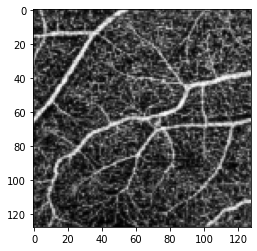

In [54]:
img = dataset[0]['A']
x = img.unsqueeze(0).cuda()
plt.imshow(img.squeeze(0), "gray")
result_save_sample(1, tensor=x, suffix="_input")

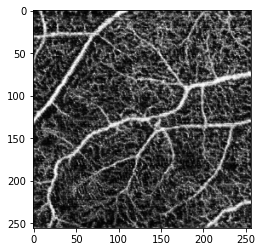

In [55]:
_, _, y = model(x)
yimg = y.cpu().detach().numpy().squeeze(0).squeeze(0)
plt.imshow(yimg, "gray")
result_save_sample(1, tensor=y, suffix="_output")

In [56]:
import cv2
upsample = cv2.resize(img.squeeze(0).cpu().numpy(), dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
upsample.shape
result_save_sample(1, img_mode=True, img=upsample, suffix="_interpolation")

(-0.5, 255.5, 255.5, -0.5)

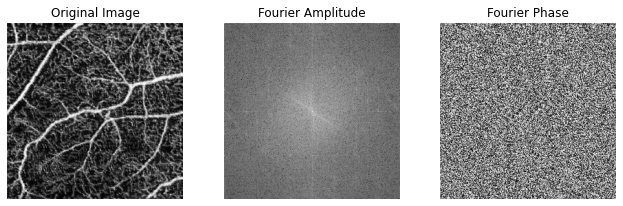

In [57]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

img = y.cpu().detach().numpy().squeeze(0).squeeze(0)
# img = y.cpu().detach().numpy().squeeze(0).squeeze(0)
f = np.fft.fft2(img, axes=(-2, -1))
fshift = np.fft.fftshift(f)
res = np.log(np.abs(fshift))
pha = np.angle(fshift)
plt.figure(figsize=(11, 11))
plt.subplot(331), plt.imshow(img, 'gray'), plt.title('Original Image')
plt.axis('off')
plt.subplot(332), plt.imshow(res, 'gray'), plt.title('Fourier Amplitude')
plt.axis('off')
plt.subplot(333), plt.imshow(pha, 'gray'), plt.title('Fourier Phase')
plt.axis('off')

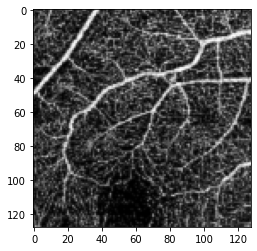

In [58]:
img = dataset[0]['A']
x = img.unsqueeze(0).cuda()
plt.imshow(img.squeeze(0), "gray")
_, _, y = model(x)

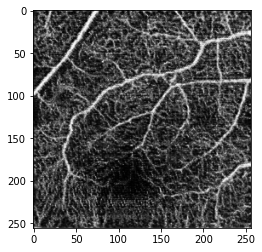

In [59]:
yimg = y.cpu().detach().numpy().squeeze(0).squeeze(0)
plt.imshow(yimg, "gray")

In [60]:
class Test_ImageDataset(Dataset):
    def __init__(self, root, transforms_test=None, unaligned=True, mode='test'):
        self.transformA = transforms.Compose(transforms_test)
        self.transformB = transforms.Compose(transforms_test)

        self.unaligned = unaligned

        self.files_A = sorted(glob.glob(os.path.join(root, '6x6_256/') + '/*.*'))
        self.files_B = sorted(glob.glob(os.path.join(root, '3x3_256/') + '/*.*'))

    def __getitem__(self, index):
        img_A = Image.open(self.files_A[index % len(self.files_A)]).convert('L')
        item_A = self.transformA(img_A)

        if self.unaligned:
            item_B = self.transformB(Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)]).convert('L'))
        else:
            item_B = self.transformB(Image.open(self.files_B[index % len(self.files_B)]).convert('L'))

        return {'A': item_A, 'B': item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

In [61]:
test_path = "./test/"
transforms_test = [ 
                transforms.ToTensor(),
                # transforms.Normalize((0.246), (0.170)),
                transforms.Normalize((0.5), (0.5)) ]
test_dataset = Test_ImageDataset(test_path, transforms_test=transforms_test, unaligned=True)

In [62]:
import cv2
img = test_dataset[2]['A']
img = cv2.resize(img.squeeze(0).cpu().numpy(), dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
x = torch.tensor(img).unsqueeze(0).unsqueeze(0).cuda()
# plt.imshow(img.squeeze(0), "gray")
_, _, y = model(x)

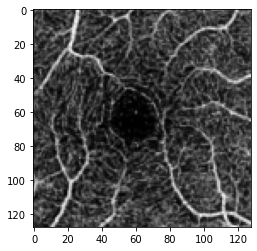

In [63]:
plt.imshow(img, "gray")

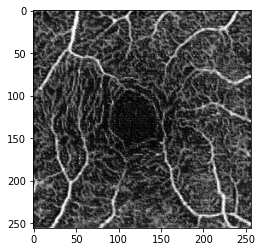

In [64]:
yimg = y.cpu().detach().numpy().squeeze(0).squeeze(0)
plt.imshow(yimg, "gray")

(-0.5, 255.5, 255.5, -0.5)

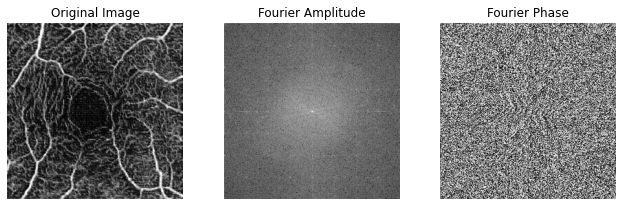

In [65]:
f = np.fft.fft2(yimg, axes=(-2, -1))
fshift = np.fft.fftshift(f)
res = np.log(np.abs(fshift))
pha = np.angle(fshift)
plt.figure(figsize=(11, 11))
plt.subplot(331), plt.imshow(yimg, 'gray'), plt.title('Original Image')
plt.axis('off')
plt.subplot(332), plt.imshow(res, 'gray'), plt.title('Fourier Amplitude')
plt.axis('off')
plt.subplot(333), plt.imshow(pha, 'gray'), plt.title('Fourier Phase')
plt.axis('off')

Pick a pair of test data to evaluate

In [66]:
netG_A2B = torch.load('./output_7.4/netG_A2B_epoch40.pth')
type(netG_A2B)
model = UnetGeneratorA2B(output_nc, input_nc).cuda()
model.load_state_dict(netG_A2B, strict=False)

<All keys matched successfully>

In [67]:
lr_img = Image.open("./test/6x6_256/270_3.png").convert('L')
hr_img = Image.open("./test/3x3_256/270_6.png").convert('L')
# lr_img = Image.open("./dataset/Colab_centered_OCTA/trainA/STDR403_20181029_101618_Angio (1)_R_001.png").convert('L')
# hr_img = Image.open("./dataset/Colab_centered_OCTA/trainB/STDR403_20181029_101802_Angio (1)_R_001.png").convert('L')
T_1 = transforms.Compose([ transforms.ToTensor(),
                transforms.Normalize((0.5), (0.5)),
                transforms.Resize([128, 128]) ])
T_2 = transforms.Compose([ transforms.ToTensor(),
                transforms.Normalize((0.5), (0.5))])
# lr_img = cv2.resize(np.array(lr_img), dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
# lr_img = torch.tensor(lr_img).unsqueeze(0).unsqueeze(0).cuda()
lr_img = T_1(lr_img).cuda().unsqueeze(0)
hr_img = T_2(hr_img).cuda().unsqueeze(0)
# lr_img.size()
_, _, sr_img = model(lr_img)

(128, 128)


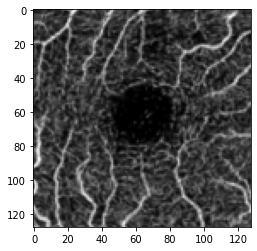

In [68]:
ximg = lr_img.cpu().detach().numpy().squeeze(0).squeeze(0)
print(ximg.shape)
plt.imshow(ximg, "gray")

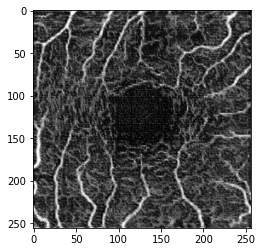

In [69]:
yimg = sr_img.cpu().detach().numpy().squeeze(0).squeeze(0)
plt.imshow(yimg, "gray")

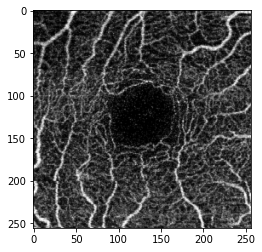

In [70]:
gtimg = hr_img.cpu().detach().numpy().squeeze(0).squeeze(0)
plt.imshow(gtimg, "gray")

In [71]:
import skimage.metrics
print(skimage.metrics.peak_signal_noise_ratio(yimg, gtimg))
print(skimage.metrics.structural_similarity(yimg, gtimg))

17.12299911871893
0.39708669242773165


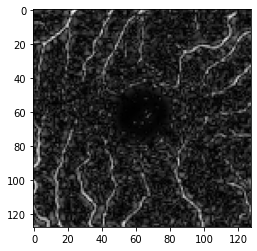

In [72]:
hp_lr_img = high_pass(lr_img[0], i = 8).cpu().detach().numpy()
plt.imshow(hp_lr_img, "gray")

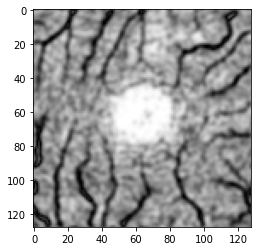

In [73]:
lp_lr_img = low_pass(lr_img[0], i = 20).cpu().detach().numpy()
plt.imshow(lp_lr_img*-1, "gray")

(-0.5, 255.5, 255.5, -0.5)

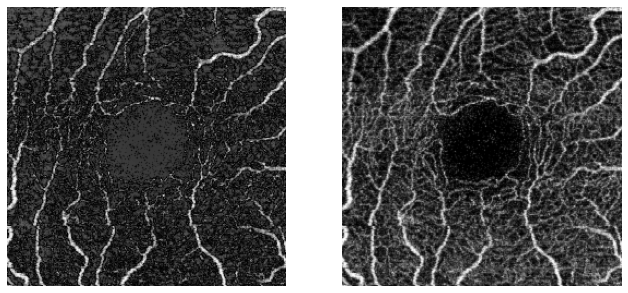

In [74]:
hp_lr_img = high_pass(hr_img[0], i = 1).cpu().detach().numpy()
# plt.imshow(hp_lr_img, "gray")
plt.figure(figsize=(11, 11))
plt.subplot(121), plt.imshow(hp_lr_img, 'gray')
plt.axis('off')
plt.subplot(122), plt.imshow(gtimg, 'gray')
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

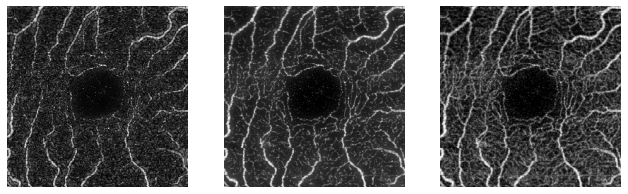

In [75]:
hp_lr_img = high_pass(hr_img[0], i = 8).cpu().detach().numpy()
plt.figure(figsize=(11, 11))
plt.subplot(131), plt.imshow(hp_lr_img, 'gray')
plt.axis('off')
plt.subplot(132), plt.imshow((gtimg+hp_lr_img)/2.0, 'gray')
plt.axis('off')
plt.subplot(133), plt.imshow(gtimg, 'gray')
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

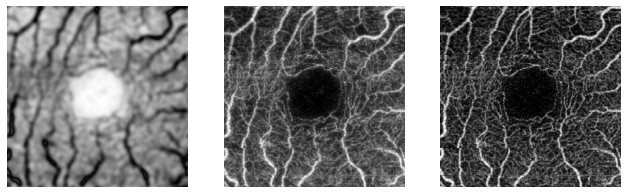

In [76]:
lp_lr_img = low_pass(hr_img[0], i = 15).cpu().detach().numpy()
plt.figure(figsize=(11, 11))
plt.subplot(131), plt.imshow(lp_lr_img*-1, 'gray')
plt.axis('off')
plt.subplot(132), plt.imshow((gtimg+lp_lr_img)/2.0, 'gray')
plt.axis('off')
plt.subplot(133), plt.imshow(gtimg, 'gray')
plt.axis('off')

# Result

In [77]:
import skimage.metrics
print(skimage.metrics.peak_signal_noise_ratio(yimg, gtimg))
print(skimage.metrics.structural_similarity(yimg, gtimg))

17.12299911871893
0.39708669242773165


In [78]:
lr_img = Image.open("./test/6x6_256/270_3.png").convert('L')
hr_img = Image.open("./test/3x3_256/270_6.png").convert('L')
lr_img = T_1(lr_img)
hr_img = T_2(hr_img)

In [79]:
input = lr_img.cuda().unsqueeze(0)
_, _, output = model(input)
output = output.cpu().detach().numpy().squeeze(0).squeeze(0)

In [80]:
ximg = lr_img.detach().numpy().squeeze(0)
yimg = hr_img.detach().numpy().squeeze(0)

In [81]:
srimg = cv2.resize(ximg, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)

(-0.5, 255.5, 255.5, -0.5)

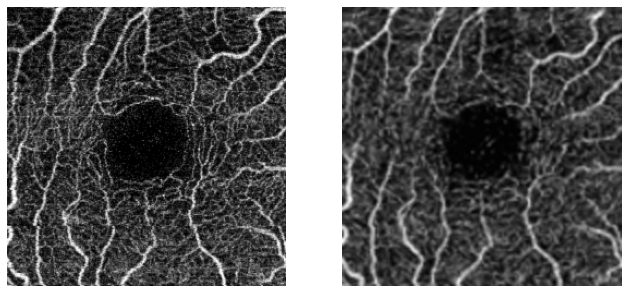

In [82]:
plt.figure(figsize=(11, 11))
plt.subplot(121), plt.imshow(yimg, 'gray')
plt.axis('off')
plt.subplot(122), plt.imshow(srimg, 'gray')
plt.axis('off')

In [83]:
print(skimage.metrics.peak_signal_noise_ratio(yimg, srimg))
print(skimage.metrics.structural_similarity(yimg, srimg))

18.86100725595916
0.4867824538889077


(-0.5, 255.5, 255.5, -0.5)

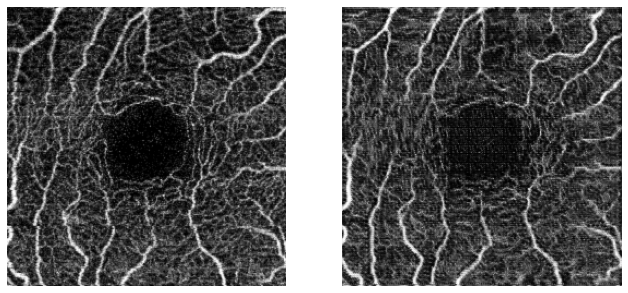

In [84]:
plt.figure(figsize=(11, 11))
plt.subplot(121), plt.imshow(yimg, 'gray')
plt.axis('off')
plt.subplot(122), plt.imshow(output, 'gray')
plt.axis('off')

In [85]:
print(skimage.metrics.peak_signal_noise_ratio(yimg, (output+srimg)/2.0))
print(skimage.metrics.structural_similarity(yimg, output))

18.618048208115628
0.39708669617032055
